# Demonstration of peeling

In [1]:
%matplotlib inline

import os
import sys

from time import clock

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)


from matplotlib import pylab

pylab.rcParams['agg.path.chunksize'] = 10000
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

from arl.data.data_models import Skycomponent
from arl.visibility.operations import create_blockvisibility, copy_visibility    
from arl.skycomponent.operations import create_skycomponent, insert_skycomponent, apply_beam_to_skycomponent
from arl.image.operations import show_image, export_image_to_fits, import_image_from_fits, qa_image, \
    create_image_from_array, copy_image, smooth_image
from arl.fourier_transforms.ftprocessor_base import create_image_from_visibility, predict_skycomponent_visibility
from arl.fourier_transforms.fft_support import extract_mid
from arl.visibility.coalesce import coalesce_visibility, decoalesce_visibility, convert_blockvisibility_to_visibility
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, create_low_test_image, create_low_test_beam, \
    create_low_test_image_from_gleam, create_low_test_skycomponents_from_gleam, simulate_gaintable
from arl.fourier_transforms.ftprocessor import *
from arl.calibration.operations import create_gaintable_from_blockvisibility, apply_gaintable
from arl.calibration.peeling import peel_skycomponent_blockvisibility

import logging
log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Make the visibility dataset

In [2]:
df = 1e6
frequency = numpy.array([1e8 - df, 1e8, 1e8 + df])
channel_bandwidth = numpy.array([df, df, df])

# Define the component and give it some spectral behaviour
f = numpy.array([100.0, 20.0, -10.0, 1.0])
flux = numpy.array([f, 0.8 * f, 0.6 * f])
phasecentre = SkyCoord(0 * u.deg, -45.0 * u.deg)

config = create_named_configuration('LOWBD2-CORE')

times = numpy.linspace(-3.0, 3.0, 7) * numpy.pi / 12.0
vis = create_blockvisibility(config, times, frequency,
                                  channel_bandwidth=channel_bandwidth,
                                  phasecentre=phasecentre, weight=1.0,
                                  polarisation_frame=PolarisationFrame('linear'))
vis.data['vis'][...]=0.0

create_blockvisibility: 7 rows, 0.056 GB


Create a peelable source, predict the visibility, simulate a gain table and then apply it to the visibilities. 

In [3]:
peeldirection = SkyCoord(+10 * u.deg, -35.0 * u.deg)
peel = Skycomponent(direction=peeldirection, frequency=frequency, flux=flux,
                    polarisation_frame=PolarisationFrame("stokesIQUV"))

vis = predict_skycomponent_blockvisibility(vis, peel)
gt = create_gaintable_from_blockvisibility(vis)
gt = simulate_gaintable(gt, phase_error=0.01, amplitude_error=0.01)
vis = apply_gaintable(vis, gt)


simulate_gaintable: Simulating amplitude error = 0.0100, phase error = 0.0100
apply_gaintable: Apply gaintable
vis_timeslice_iter: Found 7 unique times
vis_timeslice_auto: Guessing time interval to be 3600.00 s


Make the set of components that will define the main field. Then just add their visibilities to the data set.

In [4]:
sc = create_low_test_skycomponents_from_gleam(flux_limit=1.0,
                                              polarisation_frame=PolarisationFrame("stokesIQUV"),
                                              frequency=frequency, kind='cubic',
                                              phasecentre=phasecentre,
                                              radius=0.1)
model = create_image_from_visibility(vis, cellsize=0.001, npixel=512, frequency=frequency,
                                     polarisation_frame=PolarisationFrame('stokesIQUV'))

bm = create_low_test_beam(model=model)
sc = apply_beam_to_skycomponent(sc, bm)
vis = predict_skycomponent_blockvisibility(vis, sc)

create_low_test_skycomponents_from_gleam: 47 sources above flux limit 1.000
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining 3 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 0., -45.)>, starting frequency 99000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 396.276693 wavelengths
create_image_from_visibility: Critical cellsize = 0.001262 radians, 0.072293 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
import_image_from_fits: created image of shape (1, 1, 256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/timcornwell/Code/algorithm-reference-library/data/models/SKA1_LOW_beam.fits = 0.997918, 0.000000
create_low_test_beam: primary beam is defined at 100.000 MHz
create_low_test_beam: scaling to model frequency 99.000 MHz


apply_beam_to_skycomponent: Processing 47 components
apply_beam_to_skycomponent: 47 components with total flux [[ 61.16673205   0.           0.           0.        ]
 [ 59.7009979    0.           0.           0.        ]
 [ 58.29036518   0.           0.           0.        ]]


Convert the visibility data so we can image it

In [5]:
cvis = convert_blockvisibility_to_visibility(vis)

coalesce_visibility: Created new Visibility for coalesced data, coalescence factor = 0.000
coalesce_visibility: Original 7 rows, 0.056 GB, coalesced 287595 rows, 0.054 GB


Make the dirty image

invert_2d: inverting using wprojection
get_kernel_list: Using wprojection kernel
get_kernel_list: Fresnel number = 262.144000
get_kernel_list: Recommended wstep = 0.060713
get_kernel_list: Using w projection with wstep = 10.000000
get_kernel_list: Maximum w kernel full width = 126 pixels
w_kernel_list: Maximum w = 171.3 , step is 10.0 wavelengths


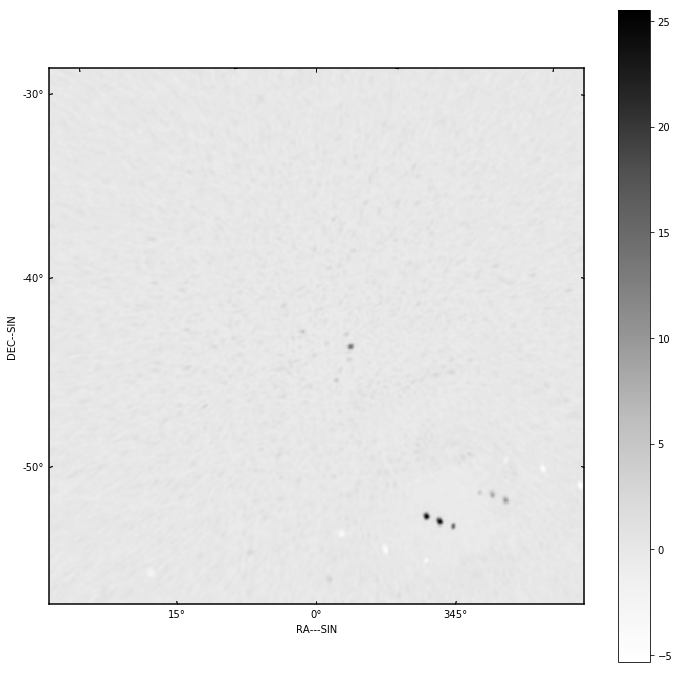

In [6]:
dirty, sumwt = invert_wprojection(cvis, model, wstep=10.0)
dirty = normalize_sumwt(dirty, sumwt)
show_image(dirty)
export_image_to_fits(dirty, "%s/peeling_dirty.fits" % (results_dir))

Finally we can peel out the source.

In [7]:
vis, peel_gts = peel_skycomponent_blockvisibility(vis, peel)

print(peel_gts[0].residual[:,0,...,0,0])

solve_gaintable: Solving for complex gain
vis_timeslice_iter: Found 7 unique times
vis_timeslice_auto: Guessing time interval to be 3600.00 s
apply_gaintable: Apply gaintable
vis_timeslice_iter: Found 7 unique times
vis_timeslice_auto: Guessing time interval to be 3600.00 s
[ 0.05338555  0.05348027  0.0529618   0.05324207  0.05329823  0.0537328
  0.05287708]


In [8]:
cvis = convert_blockvisibility_to_visibility(vis)

coalesce_visibility: Created new Visibility for coalesced data, coalescence factor = 0.000
coalesce_visibility: Original 7 rows, 0.056 GB, coalesced 287595 rows, 0.054 GB


invert_2d: inverting using wprojection
get_kernel_list: Using wprojection kernel
get_kernel_list: Fresnel number = 262.144000
get_kernel_list: Recommended wstep = 0.060713
get_kernel_list: Using w projection with wstep = 10.000000
get_kernel_list: Maximum w kernel full width = 126 pixels
w_kernel_list: Maximum w = 171.3 , step is 10.0 wavelengths


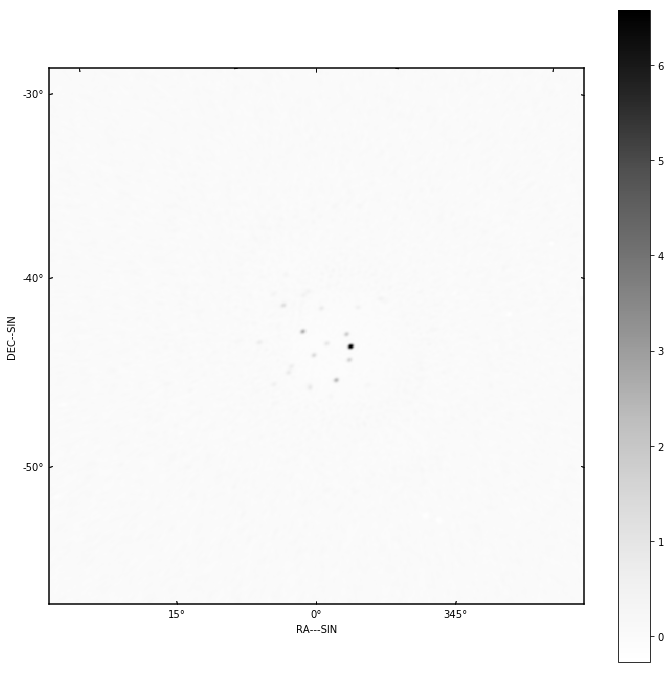

In [9]:
dirty, sumwt = invert_wprojection(cvis, model, wstep=10.0)
dirty = normalize_sumwt(dirty, sumwt)
show_image(dirty)
export_image_to_fits(dirty, "%s/peeling_dirty_peeled.fits" % (results_dir))